In [1]:
from random import seed
from random import random
from random import randrange
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Bootstrap

In [3]:
# Create a random subsample from the dataset with replacement
def subsample(X,y, ratio=1.0):
    sample_X = list()
    sample_y = list()
    n_sample = round(len(X) * ratio)
    while len(sample_X) < n_sample:
        index = randrange(len(X))
        sample_X.append(X[index])
        sample_y.append(y[index])
    return sample_X,sample_y

In [4]:
# Bootstrap Aggregation Algorithm
def bagging(X_train,y_train,X_test, n_clfs,Classifier):
    clfs = list()
    for i in range(n_clfs):
        sample_X,sample_y = subsample(X_train,y_train, sample_size)
        clf = Classifier(random_state=seed).fit(sample_X,sample_y)
        clfs.append(clf)
    y_= []
    for row in X_test:
        predictions = [clf.predict([row])[0] for clf in clfs]
        y_.append(max(set(predictions), key=predictions.count))
    return(y_)

In [5]:
def KFold_split(X, y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    y_train_folds = []
    y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        y_train_folds.append(y[kth_fold_train_idxs])
        y_val_folds.append(y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, y_train_folds, y_val_folds

In [6]:
def evaluate_algorithm(X_train_val, y_train_val, num_folds, seed, algorithm,*args):
    # Extract train and validation folds:
    X_train_folds, X_val_folds, y_train_folds, y_val_folds = KFold_split(X_train_val, y_train_val, num_folds, seed)
    scores = list()
    
    for X_train_fold, X_val_fold, y_train_fold, y_val_fold in zip(X_train_folds, X_val_folds
                                                                  , y_train_folds, y_val_folds):
        predictions = algorithm(X_train_fold,y_train_fold,X_val_fold,*args)
        scores.append(np.sum(list(predictions) == y_val_fold) / float(len(y_val_fold)))
    return scores

In [28]:

# Test bagging on the sonar dataset
seed = 2
# load and prepare data
filename = 'sonar.all-data'
dataset = pd.read_csv(filename,header=None)
X = dataset.iloc[:,:-1].to_numpy()
y = (dataset.iloc[:,-1].to_numpy()=='M').astype(int)
# evaluate algorithm
num_folds = 5
sample_size = 0.8
random.seed(seed)
# Extract a test set:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=seed)




# For each hyper-parameter instance, do KFold cross validation:
for n_trees in [1, 5, 10, 20]:
    scores = evaluate_algorithm(X_train_val, y_train_val, num_folds, seed, bagging,n_trees,DecisionTreeClassifier)
    print('Trees: %d' % n_trees)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f' % (sum(scores)/float(len(scores))))
    print('Test set Accuracy: %.3f' %(accuracy_score(bagging(X_train_val,y_train_val,X_test,n_trees
                                                             ,DecisionTreeClassifier),y_test)))

Trees: 1
Scores: [0.6896551724137931, 0.7931034482758621, 0.7241379310344828, 0.41379310344827586, 0.7586206896551724]
Mean Accuracy: 0.676
Test set Accuracy: 0.714
Trees: 5
Scores: [0.6551724137931034, 0.7586206896551724, 0.7586206896551724, 0.7931034482758621, 0.8275862068965517]
Mean Accuracy: 0.759
Test set Accuracy: 0.778
Trees: 10
Scores: [0.7586206896551724, 0.8275862068965517, 0.7586206896551724, 0.8275862068965517, 0.7241379310344828]
Mean Accuracy: 0.779
Test set Accuracy: 0.794
Trees: 20
Scores: [0.7586206896551724, 0.7931034482758621, 0.7931034482758621, 0.896551724137931, 0.7586206896551724]
Mean Accuracy: 0.800
Test set Accuracy: 0.810


# Missing numerical values

In [172]:
def load_diabetes():
    dataset = pd.read_csv('pima-indians-diabetes.csv', header=None)
    print(dataset.describe())
    return dataset

In [173]:
# print the first 20 rows of data
dataset = load_diabetes()
print(dataset.head(20))

                0           1           2           3           4           5  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

                6           7           8  
count  768.000000  768.000000  768.000000  
mean     0.471876   33.240885    0.348958  
std      0.331329   11.760232    0.476951  
min      0.078000   21.000000    0.000000  
25%      0.243750   24.000000    0.000000  
50%   

In [174]:
#TODO
#Count the number of zero values in columns [1,2,3,4,5]
print((dataset[[1,2,3,4,5]] == 0).sum())

1      5
2     35
3    227
4    374
5     11
dtype: int64


In [175]:
#TODO
# mark zero values as missing or NaN
dataset[[1,2,3,4,5]] = dataset[[1,2,3,4,5]].replace(0, np.NaN)
# count the number of NaN values in each column
print(dataset.isnull().sum())

0      0
1      5
2     35
3    227
4    374
5     11
6      0
7      0
8      0
dtype: int64


In [176]:
print(dataset.head(20))

     0      1     2     3      4     5      6   7  8
0    6  148.0  72.0  35.0    NaN  33.6  0.627  50  1
1    1   85.0  66.0  29.0    NaN  26.6  0.351  31  0
2    8  183.0  64.0   NaN    NaN  23.3  0.672  32  1
3    1   89.0  66.0  23.0   94.0  28.1  0.167  21  0
4    0  137.0  40.0  35.0  168.0  43.1  2.288  33  1
5    5  116.0  74.0   NaN    NaN  25.6  0.201  30  0
6    3   78.0  50.0  32.0   88.0  31.0  0.248  26  1
7   10  115.0   NaN   NaN    NaN  35.3  0.134  29  0
8    2  197.0  70.0  45.0  543.0  30.5  0.158  53  1
9    8  125.0  96.0   NaN    NaN   NaN  0.232  54  1
10   4  110.0  92.0   NaN    NaN  37.6  0.191  30  0
11  10  168.0  74.0   NaN    NaN  38.0  0.537  34  1
12  10  139.0  80.0   NaN    NaN  27.1  1.441  57  0
13   1  189.0  60.0  23.0  846.0  30.1  0.398  59  1
14   5  166.0  72.0  19.0  175.0  25.8  0.587  51  1
15   7  100.0   NaN   NaN    NaN  30.0  0.484  32  1
16   0  118.0  84.0  47.0  230.0  45.8  0.551  31  1
17   7  107.0  74.0   NaN    NaN  29.6  0.254 

In [177]:
#TODO
#delete rows contating NAN values from the dataset using .dropna(inplace = True) built-in function
dataset.dropna(inplace=True)
print (dataset.shape)

(392, 9)


In [178]:
values = dataset.values
X = values[:,0:8]
y = values[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=seed)


In [179]:
#TODO
#complete the function to 
#evaluate the MLP model on the test set
def evaluate_MLP(X_train, y_train,X_test,y_test,seed=7):
    model = MLPClassifier(random_state=seed).fit(X_train,y_train)
    result = model.predict(X_test)
    print(accuracy_score(model.predict(X_test),y_test))

In [180]:
evaluate_MLP(X_train, y_train,X_test,y_test,7)


0.7040816326530612


In [181]:
dataset = load_diabetes()
#TODO
# Mark zero values of columns [1,2,3,4,5] as missing or NaN
# This time fill missing values with mean column values using .fillna(dataset.mean(),inplace=True)

dataset[[1,2,3,4,5]] = dataset[[1,2,3,4,5]].replace(0, np.NaN)
dataset.fillna(dataset.mean(), inplace=True)
# count the number of NaN values in each column
print(dataset.isnull().sum())

                0           1           2           3           4           5  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

                6           7           8  
count  768.000000  768.000000  768.000000  
mean     0.471876   33.240885    0.348958  
std      0.331329   11.760232    0.476951  
min      0.078000   21.000000    0.000000  
25%      0.243750   24.000000    0.000000  
50%   

In [182]:
dataset.head(20)

,0,1,2,3,4,5,6,7,8
0,6,148.0,72.000000,35.00000,155.548223,33.600000,0.627,50,1
1,1,85.0,66.000000,29.00000,155.548223,26.600000,0.351,31,0
2,8,183.0,64.000000,29.15342,155.548223,23.300000,0.672,32,1
3,1,89.0,66.000000,23.00000,94.000000,28.100000,0.167,21,0
4,0,137.0,40.000000,35.00000,168.000000,43.100000,2.288,33,1
5,5,116.0,74.000000,29.15342,155.548223,25.600000,0.201,30,0
6,3,78.0,50.000000,32.00000,88.000000,31.000000,0.248,26,1
7,10,115.0,72.405184,29.15342,155.548223,35.300000,0.134,29,0
8,2,197.0,70.000000,45.00000,543.000000,30.500000,0.158,53,1
9,8,125.0,96.000000,29.15342,155.548223,32.457464,0.232,54,1


In [183]:
values = dataset.values
X = values[:,0:8]
y = values[:,8]
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=seed)


In [184]:
X_train.shape

(576, 8)

In [185]:
evaluate_MLP(X_train, y_train,X_test,y_test,7)

0.7142857142857143


# Imbalanced Data

In [186]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [187]:
print(df.Class.value_counts())

0    284315
1       492
Name: Class, dtype: int64


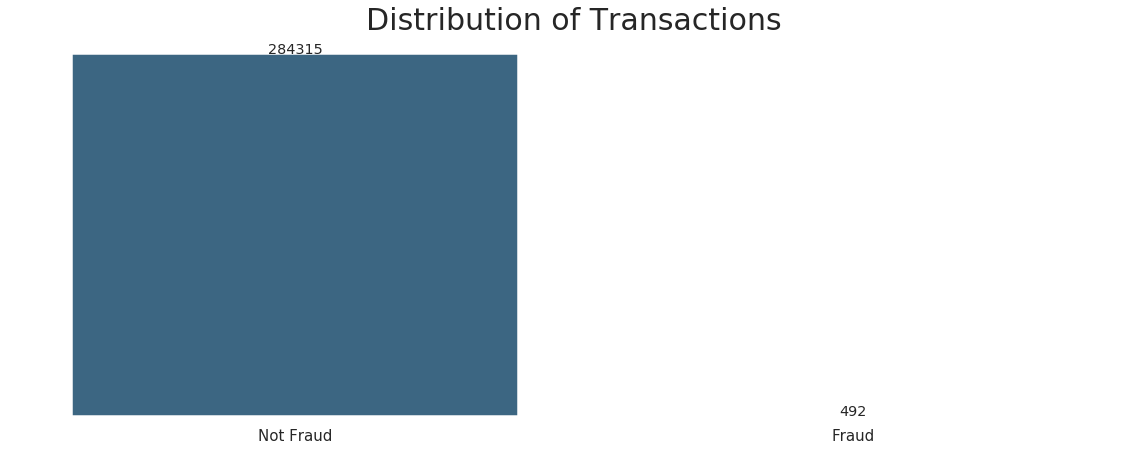

In [188]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(df.Class, palette='viridis')
g.set_xticklabels(['Not Fraud', 'Fraud'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [189]:
# TODO
# print percentage of samples where target == 1
(len(df.loc[df.Class==1])) / (len(df.loc[df.Class == 0])) * 100

0.17304750013189596

In [190]:
# Prepare data for modeling
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [116]:
#TODO
# Train a DummyClassifier to predict with 'most_frequent' strategy
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.9981461194910255


In [145]:
def evaluate_imbalanced(y_test, lr_pred):
    # Checking accuracy
    print('Accuracy: ', accuracy_score(y_test, lr_pred))
    # Checking unique values
    predictions = pd.DataFrame(lr_pred)
    print('Unique predicted labels:\n',predictions[0].value_counts())
    #recall score
    print('Recall: ',recall_score(y_test, lr_pred))
    #precision score
    print('Precision: ', precision_score(y_test, lr_pred))
    # f1 score
    print('F1 score: ',f1_score(y_test, lr_pred))
    # confusion matrix
    print('ConfMat')
    print(pd.DataFrame(confusion_matrix(y_test, lr_pred)))

In [148]:
#TODO
# Train a LogisticRegressio model on the training data
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on test set
lr_pred = lr.predict(X_test)

In [149]:
evaluate_imbalanced(y_test, lr_pred)

Accuracy:  0.9807589674447347
Unique predicted labels:
 0    69734
1     1468
Name: 0, dtype: int64
Recall:  0.8712121212121212
Precision:  0.07833787465940055
F1 score:  0.14375000000000002
ConfMat
       0     1
0  69717  1353
1     17   115


In [150]:
from sklearn.utils import resample

In [151]:
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [152]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,161634.0,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,...,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,2.74,0
163821,116237.0,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,...,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,38.44,0
72083,54557.0,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,...,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,1.00,0
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.89,0
126213,77959.0,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,...,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,237.00,0


In [153]:
# separate minority and majority classes
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

# upsample minority using resample and n_samples equal to the size of majority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [154]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)
#TODO
# Train a logistic regression on the train data
upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)
# predict on the test data
upsampled_pred = upsampled.predict(X_test)

In [155]:
evaluate_imbalanced(y_test, upsampled_pred)

Accuracy:  0.9807589674447347
Unique predicted labels:
 0    69734
1     1468
Name: 0, dtype: int64
Recall:  0.8712121212121212
Precision:  0.07833787465940055
F1 score:  0.14375000000000002
ConfMat
       0     1
0  69717  1353
1     17   115


In [156]:
# still using our separated classes fraud and not_fraud from above
# TODO
# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    360
0    360
Name: Class, dtype: int64

In [157]:
# trying logistic regression again with the undersampled dataset

y_train = downsampled.Class
X_train = downsampled.drop('Class', axis=1)

undersampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

undersampled_pred = undersampled.predict(X_test)

In [159]:
evaluate_imbalanced(y_test, undersampled_pred)

Accuracy:  0.9758574197354007
Unique predicted labels:
 0    69387
1     1815
Name: 0, dtype: int64
Recall:  0.8636363636363636
Precision:  0.0628099173553719
F1 score:  0.11710323574730355
ConfMat
       0     1
0  69369  1701
1     18   114


In [160]:
from sklearn.ensemble import RandomForestClassifier

In [163]:
df = pd.read_csv('creditcard.csv')
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [164]:
# train a random forest model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

In [165]:
evaluate_imbalanced(y_test,rfc_pred)

Accuracy:  0.9995786635206876
Unique predicted labels:
 0    71092
1      110
Name: 0, dtype: int64
Recall:  0.803030303030303
Precision:  0.9636363636363636
F1 score:  0.8760330578512396
ConfMat
       0    1
0  71066    4
1     26  106
